In [1]:
#Implicit_opt

In [2]:
import sys
sys.path.append("..")
from geomatry.opt.scipy_optimizer import SingleSystemOptimizer
from geomatry.opt_Energy_approximated.optimizer import SingleSystemOptimizer as SingleSystemOptimizer_Energy
from geomatry.opt.loss import rmsd_loss
from geomatry.ff.graph import get_given_graph_builder
from geomatry.ff.LennardJones import LennardJonesFF, _random_lj_system, _random_lj_ff_param
import torch
import copy

N = 50
N_pairs = 200
max_Za = 3
Ra, Za, idx_i, idx_j = _random_lj_system(N, N_pairs, max_Za, start_Za=1)
k, r0 = _random_lj_ff_param(max_Za, r0_max=5, k_max=5)
ff = LennardJonesFF(max_Za)
ff.reset_parameters(k, r0)

fixed_atom_indices = [0,1,2]
graph_builder = get_given_graph_builder(idx_i, idx_j)

# start implicit optimization
params_star = ff.state_dict()
print("params_star", params_star)
optimizer = SingleSystemOptimizer(
    Ra, Za, graph_builder, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)

optimizer_Energy = SingleSystemOptimizer_Energy(
    Ra, Za, graph_builder, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)


k_perturbed = torch.clamp(k.clone() + 0.01 * torch.randn_like(k), min=0)
r0_perturbed = torch.clamp(r0.clone() + 0.01 * torch.randn_like(r0), min=0)
ff.reset_parameters(k_perturbed, r0_perturbed)
params_0 = ff.state_dict()
params_0_old = copy.deepcopy(params_0)
print("params_0", params_0)
new_params_0=optimizer.optimize(params_0)
print("params_optimized",new_params_0)

params_star OrderedDict([('k', tensor([[0.0916, 2.1067, 4.6228, 1.5527],
        [2.1067, 0.3378, 3.0199, 4.4805],
        [4.6228, 3.0199, 1.9580, 3.7832],
        [1.5527, 4.4805, 3.7832, 0.2112]], dtype=torch.float64)), ('r0', tensor([[2.5434, 2.2722, 0.8315, 3.2567],
        [2.2722, 1.2064, 1.7949, 2.1352],
        [0.8315, 1.7949, 4.3948, 1.3195],
        [3.2567, 2.1352, 1.3195, 4.9542]], dtype=torch.float64))])
params_0 OrderedDict([('k', tensor([[0.0688, 2.1140, 4.6148, 1.5489],
        [2.1140, 0.3341, 3.0139, 4.4791],
        [4.6148, 3.0139, 1.9767, 3.7970],
        [1.5489, 4.4791, 3.7970, 0.2079]], dtype=torch.float64)), ('r0', tensor([[2.5566, 2.2768, 0.8314, 3.2458],
        [2.2768, 1.2031, 1.7990, 2.1317],
        [0.8314, 1.7990, 4.3984, 1.3234],
        [3.2458, 2.1317, 1.3234, 4.9607]], dtype=torch.float64))])
loss: 1.4613353694179345
loss: 1.3670964442076186
loss: 1.8383892380320435
loss: 1.357676148392244
loss: 1.7588212751299364
loss: 1.6651198637243139
loss: 1.

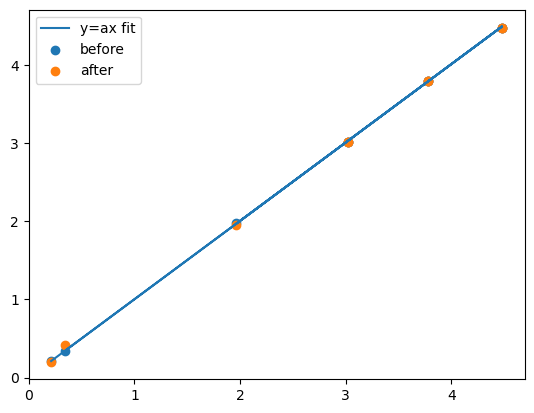

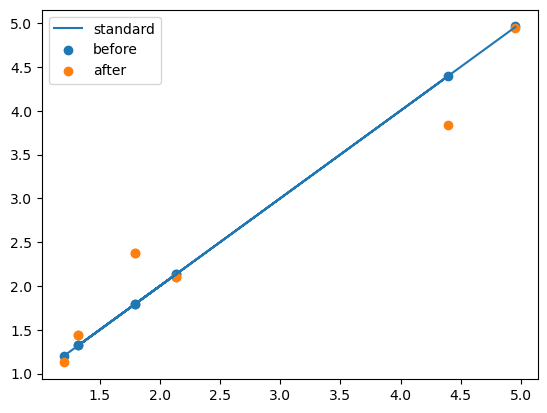

In [7]:
#Confirm
import matplotlib.pyplot as plt

new_params_0['k']=(new_params_0['k']+new_params_0['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),params_0_old['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),new_params_0['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

In [4]:
#Energy landscape opt

params_0 OrderedDict([('k', tensor([[0.0688, 2.1140, 4.6148, 1.5489],
        [2.1140, 0.3341, 3.0139, 4.4791],
        [4.6148, 3.0139, 1.9767, 3.7970],
        [1.5489, 4.4791, 3.7970, 0.2079]], dtype=torch.float64)), ('r0', tensor([[2.5566, 2.2768, 0.8314, 3.2458],
        [2.2768, 1.2031, 1.7990, 2.1317],
        [0.8314, 1.7990, 4.3984, 1.3234],
        [3.2458, 2.1317, 1.3234, 4.9607]], dtype=torch.float64))])
loss: 1.4613353694179345
1.4613353694179345


  0%|          | 0/30001 [00:00<?, ?it/s]

0 108.10194555479478 tensor(0.0046, dtype=torch.float64, grad_fn=<DivBackward0>) tensor(10.4523, dtype=torch.float64, grad_fn=<AddBackward0>)


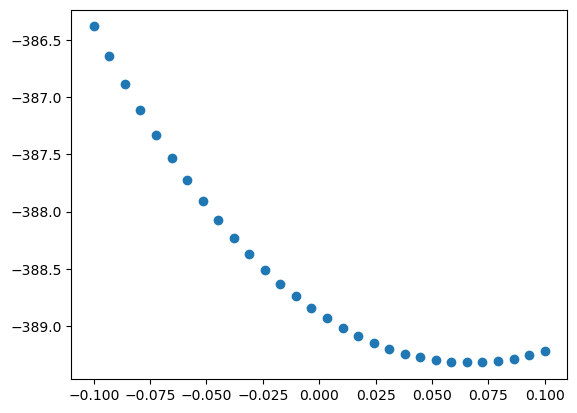

 33%|███▎      | 9978/30001 [00:35<01:10, 284.58it/s]

10000 104.42189298863279 tensor(0.0048, dtype=torch.float64, grad_fn=<DivBackward0>) tensor(7.9586, dtype=torch.float64, grad_fn=<AddBackward0>)


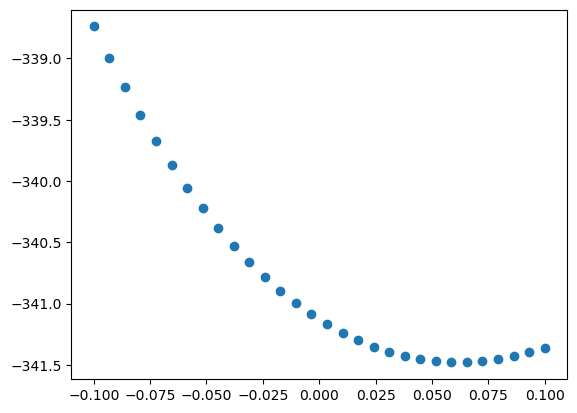

 67%|██████▋   | 19999/30001 [01:11<00:35, 284.68it/s]

20000 106.01500052490087 tensor(0.0047, dtype=torch.float64, grad_fn=<DivBackward0>) tensor(8.2817, dtype=torch.float64, grad_fn=<AddBackward0>)


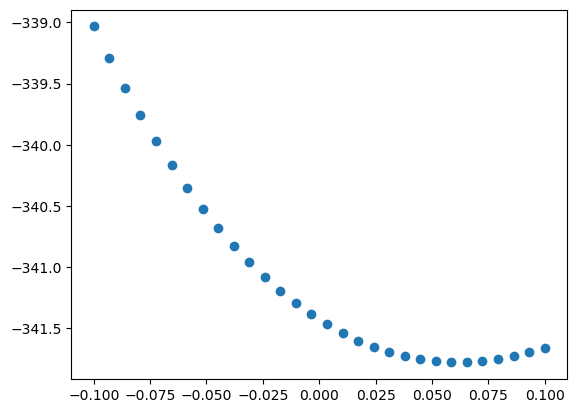

100%|█████████▉| 29998/30001 [01:47<00:00, 281.20it/s]

30000 105.05040133964118 tensor(0.0048, dtype=torch.float64, grad_fn=<DivBackward0>) tensor(7.9194, dtype=torch.float64, grad_fn=<AddBackward0>)


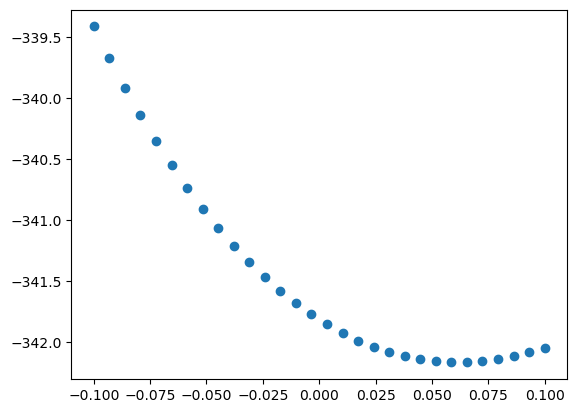

100%|██████████| 30001/30001 [01:47<00:00, 278.04it/s]

final OrderedDict([('k', tensor([[0.0688, 2.1140, 4.6148, 1.5489],
        [2.1140, 1.4274, 2.1917, 4.4328],
        [4.6148, 2.1917, 1.2379, 2.8741],
        [1.5489, 4.4328, 2.8741, 0.2954]], dtype=torch.float64)), ('r0', tensor([[2.5566, 2.2768, 0.8314, 3.2458],
        [2.2768, 1.1882, 1.7913, 2.1387],
        [0.8314, 1.7913, 4.3945, 1.3181],
        [3.2458, 2.1387, 1.3181, 4.8474]], dtype=torch.float64))])


In [11]:
def energyAndRsquare(k_perturbed, r0_perturbed, optimizer):
    ff.reset_parameters(k_perturbed, r0_perturbed)
    params_0 = ff.state_dict()
    print("params_0", params_0)
    for i in range(1):
        params_0=optimizer.optimize(params_0, 30001, 10000, 0.02, 6, 2)
    return params_0
new_params_0_Energy=energyAndRsquare(k_perturbed, r0_perturbed, optimizer_Energy)


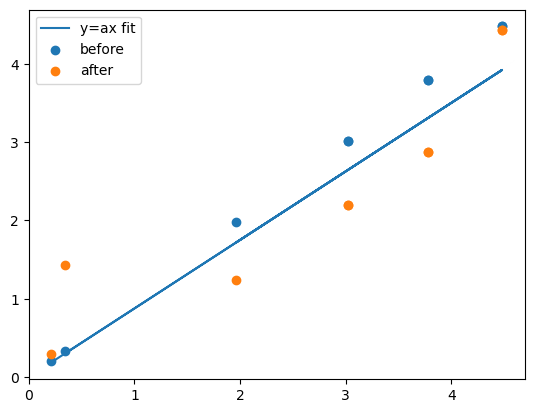

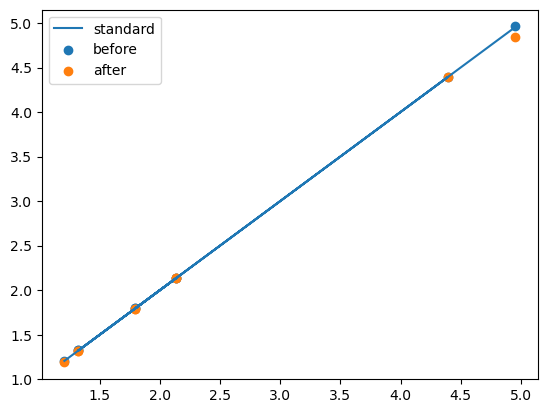

In [12]:
#Confirm
import matplotlib.pyplot as plt

new_params_0_Energy['k']=(new_params_0_Energy['k']+new_params_0_Energy['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0_Energy['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0_Energy['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),params_0_old['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),new_params_0_Energy['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()